In [52]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
import joblib

import nltk
from nltk.corpus import stopwords

import pyLDAvis
import pyLDAvis.lda_model

from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import jaccard_score, accuracy_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import mlflow
import mlflow.sklearn
from datetime import datetime

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('words')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/atfehranacz53_cb/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/atfehranacz53_cb/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/atfehranacz53_cb/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/atfehranacz53_cb/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [53]:
# L'endroit où les données seront stockées
mlflow.set_tracking_uri(os.getenv("MLFLOW_TRACKING_URI", "http://15.237.111.188:5000"))
mlflow.set_experiment("Catégoriser automatiquement des questions")  

<Experiment: artifact_location='mlflow-artifacts:/393305081072626197', creation_time=1725100131904, experiment_id='393305081072626197', last_update_time=1725100131904, lifecycle_stage='active', name='Catégoriser automatiquement des questions', tags={}>

### Fonction pour logger les paramètres, métriques, tags et artifacts dans MLflow.


In [54]:
def log_mlflow_run(run_name, parameters, metrics, model=None, model_name=None, tags=None, artifacts=None):

    try:
        # Check if there's an active run and end it if necessary
        if mlflow.active_run():
            mlflow.end_run()
        
        # Start a new MLflow run
        mlflow.start_run(run_name=run_name)
        
        # Log parameters
        if parameters:
            for key, value in parameters.items():
                mlflow.log_param(key, value)
        
        # Log metrics
        if metrics:
            for key, value in metrics.items():
                mlflow.log_metric(key, value)

        # Log tags
        if tags:
            mlflow.set_tags(tags)

        # Log artifacts
        if artifacts:
            for artifact_name, artifact_path in artifacts.items():
                mlflow.log_artifact(artifact_path, artifact_name)

        # Log the model
        if model and model_name:
            mlflow.sklearn.log_model(model, model_name)
        
        # Log the run completion timestamp
        mlflow.log_param("run_completed_at", str(datetime.now()))

    except Exception as e:
        # Log the error as a tag to help in debugging
        mlflow.set_tag("run_error", str(e))
        print(f"Erreur lors de la journalisation dans MLflow: {e}")
        
    finally:
        # Ensure the run is always ended, even in case of an error
        mlflow.end_run()


In [55]:
! export PYTHONPATH="${PYTHONPATH}:/Users/atfehranacz53_cb/Documents/OC/projet_5"

In [56]:
df_query = pd.read_csv("./data/df_query.csv")

In [57]:
condition = df_query.Title.isna()
df_query.loc[condition, 'Title'] = df_query.loc[condition, 'Body']

condition = df_query.Body.isna()
df_query.loc[condition, 'Body'] = df_query.loc[condition, 'Title']


In [58]:
df_query = df_query.dropna(subset=['Title', 'Body'])

In [59]:
df_query

,Title,Body,Tags,Score,ViewCount,AnswerCount
0,process sorted array fast process unsorted array,c++ code sort datum time region make primary l...,java prediction c++ branch cpu architecture pe...,27284,1890740,25
1,delete git branch locally remotely,fail attempt delete remote branch pre class la...,control git push branch version remote,20374,11680196,41
2,operator c++,read href http group google com group comp lan...,c++ standard format compliance operator code,10165,1016567,26
3,force git pull overwrite local file,force overwrite local file code git pull code ...,control git pull version fetch overwrite,9710,8669682,54
4,stack heap,stack heap locate physically computer memory e...,heap dynamic structure memory allocation data ...,9441,1945819,31
...,...,...,...,...,...,...
49995,microsoft azure different subnet vnet,microsoft azure different subnet vnet azure ne...,cloud machine service azureportal azure networ...,5,26861,3
49996,jquery validation rules statement,code work need basically field length check zi...,ajax jquery validationrule javascript validate,5,35834,2
49997,material datepicker custom renderinput,recently start material react typescript proje...,material reactjs typescript javascript datepicker,5,25504,2
49998,use request post proxy authentication python,pre code import beautifulsoup import request r...,post python beautifulsoup proxy http,5,34425,1


In [60]:
df_query_train, df_query_val = train_test_split(df_query, test_size=0.5, random_state=88)

In [61]:
vectorizer = TfidfVectorizer(max_features=512, stop_words='english')

bow = vectorizer.fit_transform(df_query_train.Title + ' ' + df_query_train.Body)
bow_val = vectorizer.transform(df_query_val.Title + ' ' + df_query_val.Body)

X = pd.DataFrame(bow.toarray(), index=df_query_train.index, columns=vectorizer.get_feature_names_out())
X_val = pd.DataFrame(bow_val.toarray(), index=df_query_val.index, columns=vectorizer.get_feature_names_out())


In [62]:
vectorizer

TfidfVectorizer(max_features=512, stop_words='english')

In [63]:
binarizer = CountVectorizer(binary=True, max_features=100, stop_words='english')

bow_cible = binarizer.fit_transform(df_query_train.Tags)
bow_val_cible = binarizer.transform(df_query_val.Tags)

y = pd.DataFrame(bow_cible.toarray(), index=df_query_train.index, columns=binarizer.get_feature_names_out())
y_val = pd.DataFrame(bow_val_cible.toarray(), index=df_query_val.index, columns=binarizer.get_feature_names_out())

In [64]:
with mlflow.start_run(run_name="TfidfVectorizer") as run:
    # Enregistrer le vectorizer en tant qu'artefact
    vectorizer_path = "vectorizer.pkl"
    joblib.dump(vectorizer, vectorizer_path)
    mlflow.log_artifact(vectorizer_path, "tfidf_vectorizer")
    os.remove(vectorizer_path)

In [65]:
with mlflow.start_run(run_name="Binarizer") as run:
    # Enregistrer le binarizer en tant qu'artefact
    binarizer_path = "binarizer.pkl"
    joblib.dump(binarizer, binarizer_path)
    mlflow.log_artifact(binarizer_path, "binarizer")
    os.remove(binarizer_path)

# Classification avec Bag-of-words TF-IDF


## REGRESSION LOGISTIQUE

In [50]:
def coverage_score(predictions, actuals):
    # Assuming a coverage score calculation based on overlap of predicted and actual tags
    total_tags = sum(len(tags.split()) for tags in actuals)
    covered_tags = sum(len(set(pred.split()) & set(act.split())) for pred, act in zip(predictions, actuals))
    return covered_tags / total_tags if total_tags > 0 else 0

In [22]:
classifier = OneVsRestClassifier(LogisticRegression())
classifier.fit(X, y)
y_pred = classifier.predict(X_val)

In [23]:
score_reference = jaccard_score(y_val, y_pred, average='weighted')
score_reference

0.35415499625278096

In [24]:
df_query_val

,Title,Body,Tags,Score,ViewCount,AnswerCount
11071,close tab window sublime text,way close tab sublime text leave window curren...,sublimetext shortcut keyboard,69,38646,7
19900,android download intent,wonder intent download url browser download st...,android url download browser intent,38,40968,4
25325,boost compile msvc,build boost try version href http www boost or...,visual c++ studio- boost build,28,36697,6
31006,getaddrinfo ipv,try understand getaddrinfo function return pre...,getaddrinfo ipv programming network,21,30118,4
37002,bootstrap hide dropdown menu menu item click,href http jsfiddle net strong check fiddle str...,uinavigationbar bootstrap jquery design drop t...,15,46062,6
...,...,...,...,...,...,...
4039,hilt unsupported metadata version kotlin,try run code kotlin plugin pre code plugin com...,kotlin android dagger hilt compose studio jetp...,165,133347,25
32611,version glibc find,try install pytorch armv -bit architecture pyt...,pytorch ubuntu- glibc docker libc,19,121430,5
44234,trigger viewmodel command specific button event,command viewmodel invoke specific event button...,mouseevent button command wpf mvvm,10,36014,3
20297,floatmath math cast,late update android api href http developer an...,java android lint float double point,37,31044,4


In [25]:
tags_pred = pd.Series(binarizer.inverse_transform(y_pred), index=df_query_val.index).apply(lambda x: ' '.join(x))
coverage_reference = coverage_score(tags_pred, df_query_val.Tags)
coverage_reference

0.16270633848322857

In [26]:
params = {'algorithme' : 'Regression_logistique'}
metrics = {'jaccard_score' : score_reference,
           'taux_de_couverture' : coverage_reference}
tags = {'Dataset' : 'BOW_tfidf', 'algorithme' : 'Regression_logistique'}

log_mlflow_run('Regression logistique (TF-IDF)', params, metrics, tags=tags, model=classifier, model_name='Regression_logistique')

/opt/homebrew/Caskroom/miniconda/base/envs/new_env/lib/python3.10/importlib/__init__.py:126: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  return _bootstrap._gcd_import(name[level:], package, level)


## SGDClassifier AVEC UNE PÉNALITÉ L2

In [27]:
alphas = np.logspace(-8, -4, 10)
score = []
coverage = []

for alpha in alphas:
    classifier = OneVsRestClassifier(SGDClassifier(alpha=alpha, penalty='l2', loss='log_loss', random_state=72))
    classifier.fit(X, y)
    
    y_pred = classifier.predict(X_val)
    score.append(jaccard_score(y_val, y_pred, average='weighted'))
    
    tags_pred = pd.Series(binarizer.inverse_transform(y_pred), index=df_query_val.index).apply(lambda x: ' '.join(x))
    coverage.append(coverage_score(tags_pred, df_query_val.Tags))

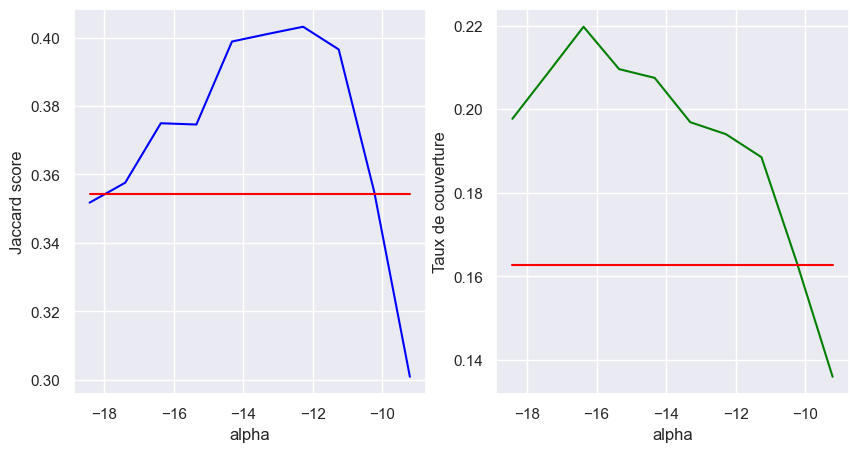

In [28]:
sns.set(style='darkgrid')
fig, axe = plt.subplots(1,2,figsize = (10,5))
axe = axe.flatten()
sns.lineplot(x=np.log(alphas), y=score, ax=axe[0], color='blue')
sns.lineplot(x=np.log(alphas), y=score_reference, ax=axe[0], color='red')
axe[0].set_xlabel('alpha')
axe[0].set_ylabel('Jaccard score')
sns.lineplot(x=np.log(alphas), y=coverage, ax=axe[1], color='green')
sns.lineplot(x=np.log(alphas), y=coverage_reference, ax=axe[1], color='red')
axe[1].set_xlabel('alpha')
axe[1].set_ylabel('Taux de couverture')
plt.show()

In [29]:
alpha_optimal = alphas[np.argmax(coverage)]
alpha_optimal

7.742636826811277e-08

In [30]:
score[np.argmax(coverage)]

0.37495661042065437

In [31]:
max(coverage)

0.2197174411090877

In [32]:
classifier = OneVsRestClassifier(SGDClassifier(alpha=alpha_optimal, penalty='l2', loss='log_loss', random_state=72))
classifier.fit(X, y)

OneVsRestClassifier(estimator=SGDClassifier(alpha=7.742636826811277e-08,
                                            loss='log_loss', random_state=72))

In [33]:
params = {'algorithme' : 'SGDClassifier', 'loss' : 'log_loss', 'penalty' : 'l2', 'alpha_optimal' : alpha_optimal}
metrics = {'jaccard_score' : score[np.argmax(coverage)],
           'taux_de_couverture' : max(coverage)}
tags = {'Dataset' : 'BOW_tfidf', 'algorithme' : 'SGDClassifier'}

log_mlflow_run('SGDClassifier_l2 (TF-IDF)', params, metrics, tags=tags, model=classifier, model_name='SGDClassifier')

/opt/homebrew/Caskroom/miniconda/base/envs/new_env/lib/python3.10/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/new_env/lib/python3.10/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
/opt/homebrew/Caskroom/miniconda/base/envs/new_env/lib/python3.10/importlib/__init__.py:126: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  return 

# Classification avec Embedding Word2Vec


## REGRESSION LOGISTIQUE

In [34]:
from gensim.models import Word2Vec

In [35]:
sentences = [title.split() for title in df_query_train.Title] + [question.split() for question in df_query_train.Body]
embedding = Word2Vec(sentences, vector_size=100, min_count=1, sg=1, window=7)

In [36]:
embedding.wv.most_similar('tensorflow')

[('keras', 0.7980261445045471),
 ('op', 0.791448712348938),
 ('get_default_graph', 0.7897321581840515),
 ('anaconda', 0.7861627340316772),
 ('tensorboard', 0.785528302192688),
 ('theano', 0.7790517807006836),
 ('mixed_precision', 0.7777632474899292),
 ('kera', 0.7755013108253479),
 ('pytorch', 0.7752783894538879),
 ('xgboost', 0.7535185813903809)]

In [37]:
def get_vector(embedding, text):
    return np.mean([embedding.wv[word] for word in text.split() if word in embedding.wv], axis=0)

In [38]:
X = pd.DataFrame((df_query_train.Title + ' ' + df_query_train.Body).apply(lambda x: get_vector(embedding, x)).tolist(), index=df_query_train.index)
X_val = pd.DataFrame((df_query_val.Title + ' ' + df_query_val.Body).apply(lambda x: get_vector(embedding, x)).tolist(), index=df_query_val.index)

In [39]:
classifier = OneVsRestClassifier(LogisticRegression())
classifier.fit(X, y)
y_pred = classifier.predict(X_val)

In [40]:
score_reference = jaccard_score(y_val, y_pred, average='weighted')
score_reference

0.3320632832326812

In [41]:
tags_pred = pd.Series(binarizer.inverse_transform(y_pred), index=df_query_val.index).apply(lambda x: ' '.join(x))
coverage_reference = coverage_score(tags_pred, df_query_val.Tags)
coverage_reference

0.15675116019503024

In [42]:
params = {'algorithme' : 'LogisticRegression'}
metrics = {'jaccard_score' : score_reference,
           'taux_de_couverture' : coverage_reference}
tags = {'Dataset' : 'Word2Vec', 'algorithme' : 'SGDClassifier'}

log_mlflow_run('Regression logistique (Word2Vec)', params, metrics, tags=tags, model=classifier, model_name='LogisticRegression')

/opt/homebrew/Caskroom/miniconda/base/envs/new_env/lib/python3.10/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/new_env/lib/python3.10/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
/opt/homebrew/Caskroom/miniconda/base/envs/new_env/lib/python3.10/importlib/__init__.py:126: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  return 

## SGDClassifier AVEC UNE PÉNALITÉ L2

In [43]:
alphas = np.logspace(-8, -4, 10)
score = []
coverage = []

for alpha in alphas:
    classifier = OneVsRestClassifier(SGDClassifier(alpha=alpha, penalty='l2', loss='log_loss', random_state=72))
    classifier.fit(X, y)
    
    y_pred = classifier.predict(X_val)
    score.append(jaccard_score(y_val, y_pred, average='weighted'))
    
    tags_pred = pd.Series(binarizer.inverse_transform(y_pred), index=df_query_val.index).apply(lambda x: ' '.join(x))
    coverage.append(coverage_score(tags_pred, df_query_val.Tags))

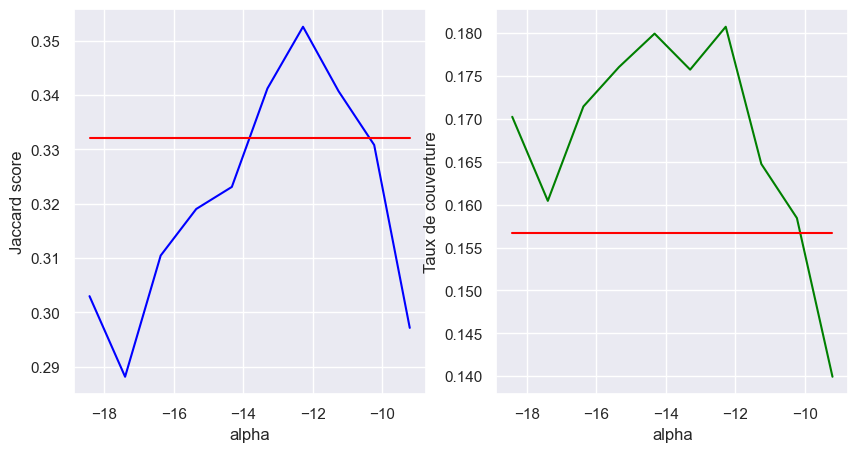

In [44]:
sns.set(style='darkgrid')
fig, axe = plt.subplots(1,2,figsize = (10,5))
axe = axe.flatten()
sns.lineplot(x=np.log(alphas), y=score, ax=axe[0], color='blue')
sns.lineplot(x=np.log(alphas), y=score_reference, ax=axe[0], color='red')
axe[0].set_xlabel('alpha')
axe[0].set_ylabel('Jaccard score')
sns.lineplot(x=np.log(alphas), y=coverage, ax=axe[1], color='green')
sns.lineplot(x=np.log(alphas), y=coverage_reference, ax=axe[1], color='red')
axe[1].set_xlabel('alpha')
axe[1].set_ylabel('Taux de couverture')
plt.show()

In [45]:
alpha_optimal = alphas[np.argmax(coverage)]
print(score[np.argmax(coverage)])
print(max(coverage))

0.3526150332325519
0.1807481055043177


In [46]:
classifier = OneVsRestClassifier(SGDClassifier(alpha=alpha_optimal, penalty='l2', loss='log_loss', random_state=72))
classifier.fit(X, y)

OneVsRestClassifier(estimator=SGDClassifier(alpha=4.641588833612773e-06,
                                            loss='log_loss', random_state=72))

In [47]:
params = {'algorithme' : 'SGDClassifier', 'loss' : 'log_loss', 'penalty' : 'l2', 'alpha_optimal' : alpha_optimal}
metrics = {'jaccard_score' : score[np.argmax(coverage)],
           'taux_de_couverture' : max(coverage)}
tags = {'Dataset' : 'Word2Vec', 'algorithme' : 'SGDClassifier'}

log_mlflow_run('SGDClassifier_l2 (Word2Vec)', params, metrics, tags=tags, 
                  model=classifier, model_name='SGDClassifier')

/opt/homebrew/Caskroom/miniconda/base/envs/new_env/lib/python3.10/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/new_env/lib/python3.10/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
/opt/homebrew/Caskroom/miniconda/base/envs/new_env/lib/python3.10/importlib/__init__.py:126: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  return 

## Classification avec Embedding BERT

### Regression logistique

In [33]:
from transformers import DistilBertTokenizer, DistilBertModel
import torch

In [34]:
def get_bert_embeddings(texts, batch_size=16):

    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    model = DistilBertModel.from_pretrained('distilbert-base-uncased')

    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=32)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings.append(outputs.last_hidden_state.mean(dim=1).numpy())

    return np.concatenate(embeddings, axis=0)

In [35]:
# Ensure the inputs are correctly formatted as lists of strings
train_texts = (df_query_train.Title + ' ' + df_query_train.Body).tolist()
val_texts = (df_query_val.Title + ' ' + df_query_val.Body).tolist()

# Obtain the embeddings for the training and validation sets
bert_train = get_bert_embeddings(train_texts)
bert_val = get_bert_embeddings(val_texts)


In [36]:
classifier = OneVsRestClassifier(LogisticRegression(max_iter=300))
classifier.fit(bert_train, y)
y_pred = classifier.predict(bert_val)

In [37]:
score_reference = jaccard_score(y_val, y_pred, average='weighted')
score_reference

0.3512383176998724

In [40]:
tags_pred = pd.Series(binarizer.inverse_transform(y_pred), index=df_query_val.index).apply(lambda x: ' '.join(x))
coverage_reference = coverage_score(tags_pred, df_query_val.Tags)
coverage_reference

0.16303677377665513

In [41]:
params = {'algorithme' : 'LogisticRegression'}
metrics = {'jaccard_score' : score_reference,
           'taux_de_couverture' : coverage_reference}
tags = {'Dataset' : 'BERT', 'algorithme' : 'LogisticRegression'}

log_mlflow_run('Regression logistique (BERT)', params, metrics, tags=tags, model=classifier, model_name='LogisticRegression')

## SGDClassifier AVEC UNE PÉNALITÉ L2

In [42]:
alphas = np.logspace(-8, -4, 10)
score = []
coverage = []

for alpha in alphas:
    classifier = OneVsRestClassifier(SGDClassifier(alpha=alpha, penalty='l2', loss='log_loss', random_state=72))
    classifier.fit(bert_train, y)
    
    y_pred = classifier.predict(bert_val)
    score.append(jaccard_score(y_val, y_pred, average='weighted'))
    
    tags_pred = pd.Series(binarizer.inverse_transform(y_pred), index=df_query_val.index).apply(lambda x: ' '.join(x))
    coverage.append(coverage_score(tags_pred, df_query_val.Tags))

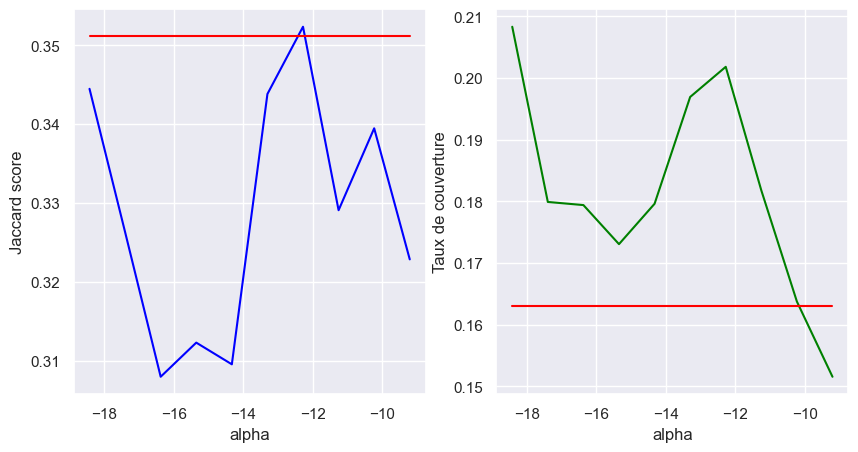

In [43]:
sns.set(style='darkgrid')
fig, axe = plt.subplots(1,2,figsize = (10,5))
axe = axe.flatten()
sns.lineplot(x=np.log(alphas), y=score, ax=axe[0], color='blue')
sns.lineplot(x=np.log(alphas), y=score_reference, ax=axe[0], color='red')
axe[0].set_xlabel('alpha')
axe[0].set_ylabel('Jaccard score')
sns.lineplot(x=np.log(alphas), y=coverage, ax=axe[1], color='green')
sns.lineplot(x=np.log(alphas), y=coverage_reference, ax=axe[1], color='red')
axe[1].set_xlabel('alpha')
axe[1].set_ylabel('Taux de couverture')
plt.show()

In [44]:
alpha_optimal = alphas[np.argmax(coverage)]
alpha_optimal

1e-08

In [45]:
score[np.argmax(coverage)]

0.3444816757366112

In [46]:
max(coverage)

0.20832109498913234

In [47]:
classifier = OneVsRestClassifier(SGDClassifier(alpha=alpha_optimal, penalty='l2', loss='log_loss', random_state=72))
classifier.fit(bert_train, y)

OneVsRestClassifier(estimator=SGDClassifier(alpha=1e-08, loss='log_loss',
                                            random_state=72))

In [48]:
params = {'algorithme' : 'SGDClassifier', 'loss' : 'log_loss', 'penalty' : 'l2', 'alpha_optimal' : alpha_optimal}
metrics = {'jaccard_score' : score[np.argmax(coverage)],
           'taux_de_couverture' : max(coverage)}
tags = {'Dataset' : 'BERT', 'algorithme' : 'SGDClassifier'}

log_mlflow_run('SGDClassifier_l2 (BERT)', params, metrics, tags=tags, model=classifier, model_name='SGDClassifier')

/opt/homebrew/Caskroom/miniconda/base/envs/tensorflow-metal/lib/python3.9/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/tensorflow-metal/lib/python3.9/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


# Classification avec Embedding USE


In [3]:
import tensorflow_hub as hub

# Charger le modèle USE
model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [8]:
# Fonction pour obtenir les embeddings USE (par lots)
def get_use_embeddings(texts, batch_size=8):
    all_embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        batch_embeddings = model(batch_texts).numpy()
        all_embeddings.append(batch_embeddings)
    return np.concatenate(all_embeddings, axis=0)


## Regression logistique

In [24]:

# Obtenir les embeddings pour l'ensemble d'entraînement et de test
use_train = get_use_embeddings((df_query_train.Title + ' ' + df_query_train.Body).tolist())

In [25]:
use_val = get_use_embeddings((df_query_val.Title + ' ' + df_query_val.Body).tolist())

In [26]:
classifier = OneVsRestClassifier(LogisticRegression())
classifier.fit(use_train, y)
y_pred = classifier.predict(use_val)

In [27]:
score_reference = jaccard_score(y_val, y_pred, average='weighted')
score_reference

0.3947733009315148

In [28]:
tags_pred = pd.Series(binarizer.inverse_transform(y_pred), index=df_query_val.index).apply(lambda x: ' '.join(x))
coverage_reference = coverage_score(tags_pred, df_query_val.Tags)
coverage_reference

0.18465458497327145

In [29]:
params = {'algorithme' : 'LogisticRegression'}
metrics = {'jaccard_score' : score_reference,
           'taux_de_couverture' : coverage_reference}
tags = {'Dataset' : 'USE', 'algorithme' : 'LogisticRegression'}

log_mlflow_run('Regression logistique (USE)', params, metrics, tags=tags, model=classifier, model_name='LogisticRegression')

/opt/homebrew/Caskroom/miniconda/base/envs/tensorflow-metal/lib/python3.9/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


## SGDClassifier AVEC UNE PÉNALITÉ L2

In [30]:
alphas = np.logspace(-8, -4, 10)
score = []
coverage = []

for alpha in alphas:
    classifier = OneVsRestClassifier(SGDClassifier(alpha=alpha, penalty='l2', loss='log_loss', random_state=72))
    classifier.fit(use_train, y)
    
    y_pred = classifier.predict(use_val)
    score.append(jaccard_score(y_val, y_pred, average='weighted'))
    
    tags_pred = pd.Series(binarizer.inverse_transform(y_pred), index=df_query_val.index).apply(lambda x: ' '.join(x))
    coverage.append(coverage_score(tags_pred, df_query_val.Tags))

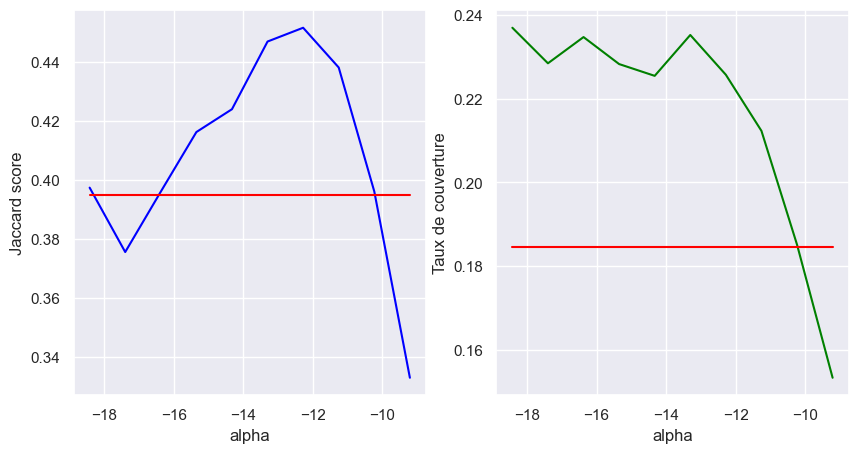

In [31]:
sns.set(style='darkgrid')
fig, axe = plt.subplots(1,2,figsize = (10,5))
axe = axe.flatten()
sns.lineplot(x=np.log(alphas), y=score, ax=axe[0], color='blue')
sns.lineplot(x=np.log(alphas), y=score_reference, ax=axe[0], color='red')
axe[0].set_xlabel('alpha')
axe[0].set_ylabel('Jaccard score')
sns.lineplot(x=np.log(alphas), y=coverage, ax=axe[1], color='green')
sns.lineplot(x=np.log(alphas), y=coverage_reference, ax=axe[1], color='red')
axe[1].set_xlabel('alpha')
axe[1].set_ylabel('Taux de couverture')
plt.show()

In [32]:
alpha_optimal = alphas[np.argmax(coverage)]
alpha_optimal

1e-08

In [33]:
score[np.argmax(coverage)]

0.3972457266871548

In [34]:
max(coverage)

0.23690007636726781

In [35]:
classifier = OneVsRestClassifier(SGDClassifier(alpha=alpha_optimal, penalty='l2', loss='log_loss', random_state=72))
classifier.fit(use_train, y)

OneVsRestClassifier(estimator=SGDClassifier(alpha=1e-08, loss='log_loss',
                                            random_state=72))

In [36]:
params = {'algorithme' : 'SGDClassifier', 'loss' : 'log_loss', 'penalty' : 'l2', 'alpha_optimal' : alpha_optimal}
metrics = {'jaccard_score' : score[np.argmax(coverage)],
           'taux_de_couverture' : max(coverage)}
tags = {'Dataset' : 'USE', 'algorithme' : 'SGDClassifier'}

log_mlflow_run('SGDClassifier_l2 (USE)', params, metrics, tags=tags, model=classifier, model_name='SGDClassifier')

In [37]:
with mlflow.start_run():
    # Enregistrer le modèle dans le registre de modèles
    mlflow.sklearn.log_model(
        sk_model=classifier,
        artifact_path="model",
        registered_model_name="SGDClassifier_l2 (USE)"
    )

Successfully registered model 'SGDClassifier_l2 (USE)'.
2024/08/31 16:19:22 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: SGDClassifier_l2 (USE), version 1
Created version '1' of model 'SGDClassifier_l2 (USE)'.
